### PROJETO 1 REDES SOCIAIS

**GRUPO D:** 
- ESTHER DAGIR
- FELIPE LEMOS
- JV PAZOTTI

**DESCRIÇÃO DATASET CORD19**

Artigos acadêmicos relacionados ao COVID-19 e suas variantes que integram o dataset CORD-19. Coleção mais extensa (+134.000 artigos) de pesquisa sobre coronavírus legível por máquina disponível para mineração de dados até o momento, solicitada pelo governo americano em conjunto com entidades de pesquisa sobre o vírus e suas variantes. 

### Importando as Bibliotecas


In [1]:
import pandas as pd
import seaborn as sns
import netpixi
from netpixi.integration.gt import *
from regression.integration.gt import *

<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()


### Dataset

In [2]:
data = pd.read_csv("metadata.csv")

/tmp/ipykernel_135/304384523.py:1: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("metadata.csv")


In [3]:
unique_journals = data['journal'].unique().tolist()
len(unique_journals)

54994

In [4]:
unique_df = data.drop_duplicates(subset=['journal'])

In [5]:
data=unique_df
unique_df.shape

(54994, 19)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54994 entries, 0 to 1056494
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cord_uid          54994 non-null  object 
 1   sha               10908 non-null  object 
 2   source_x          54994 non-null  object 
 3   title             54971 non-null  object 
 4   doi               33869 non-null  object 
 5   pmcid             12731 non-null  object 
 6   pubmed_id         13891 non-null  object 
 7   license           54994 non-null  object 
 8   abstract          44920 non-null  object 
 9   publish_time      54966 non-null  object 
 10  authors           53561 non-null  object 
 11  journal           54993 non-null  object 
 12  mag_id            0 non-null      float64
 13  who_covidence_id  35174 non-null  object 
 14  arxiv_id          47 non-null     object 
 15  pdf_json_files    10908 non-null  object 
 16  pmc_json_files    9110 non-null   obje

In [7]:
data=data.copy().drop(columns=['pdf_json_files','pmc_json_files','arxiv_id','pmcid','mag_id','s2_id'])

In [8]:
data['authors'] = data['authors'].astype(str)

### Construindo a rede de coautoria

In [9]:
g = Graph(directed=False) # não dirigido

In [10]:
collabs = {}

# percorre todos os autores no dataset
for authors in data['authors']:
    # divide os autores em uma lista
    authors_list = authors.split('; ')
    # percorre todos os pares de autores na lista
    for i in range(len(authors_list)):
        for j in range(i+1, len(authors_list)):
            # ordena os nomes dos autores em ordem alfabética para evitar duplicatas
            pair = tuple(sorted([authors_list[i], authors_list[j]]))
            # incrementa o contador de co-autorias para esse par de autores
            collabs[pair] = collabs.get(pair, 0) + 1    
            
co_authors = [] #todos os influentes

# seleciona os autores que fizeram pelo menos 2 co-autorias (threshold)
for pair, count in collabs.items():
    if count >= 2: 
        # adiciona os autores da co-autoria à lista de autores colaboradores influentes
        co_authors.extend(pair)
        
unique_authors = set(co_authors)

In [30]:
import numpy as np
np.mean(list(collabs.values()))

1.023443987867939

In [11]:
for author in unique_authors:
    g.add_vertex(author) 
    
for pair, count in collabs.items():
    try:
        if count >= 2 and pair[0] in unique_authors and pair[1] in unique_authors:
            if pair[0]!= pair[1]:
                g.add_edge(pair[0], pair[1])
    except ValueError as e:
        print("Erro ao adicionar a aresta {}: {}".format(pair, e))


In [12]:
cord19 = gt_data(g)

In [13]:
n = g.num_vertices()
m =  g.num_edges()
max_edges = n * (n - 1) if g.is_directed() else n * (n - 1) // 2
d = m / max_edges

print('Número de vértices de g:', n)
print('Número de arestas de g:', m)
print('Máximo possível de arestas de g:', max_edges)
print('Densidade de g:', d)

Número de vértices de g: 13628
Número de arestas de g: 89663
Máximo possível de arestas de g: 92854378
Densidade de g: 0.0009656302904748336


In [14]:
in_degrees = [] 
for v in g.all_vertices():
    in_degrees.append(v.in_degree())

out_degrees = []
for v in g.all_vertices():
    out_degrees.append(v.out_degree())

degrees = []
for v in g.all_vertices():
    degrees.append(v.total_degree())
    
cord19['in_degree'] = in_degrees
cord19['out_degree'] = out_degrees
cord19['degree'] = degrees
cord19

,in_degree,out_degree,degree
id,,,
"Odagiri, Takato",0,1,1
"Jain, Rahul",0,7,7
"Wang, Chenjiao",0,9,9
"Taylor, Robert",0,2,2
"Reddy, Ugan",0,8,8
...,...,...,...
"Alesi, Viola",0,15,15
"Yu, Kaihuan",0,1,1
"Wedervang, K",0,16,16


In [15]:
cord19.to_csv('cord19.csv')

count    13628.000000
mean        13.158644
std         95.182876
min          1.000000
25%          3.000000
50%          6.000000
75%         14.000000
max       2320.000000
Name: degree, dtype: float64

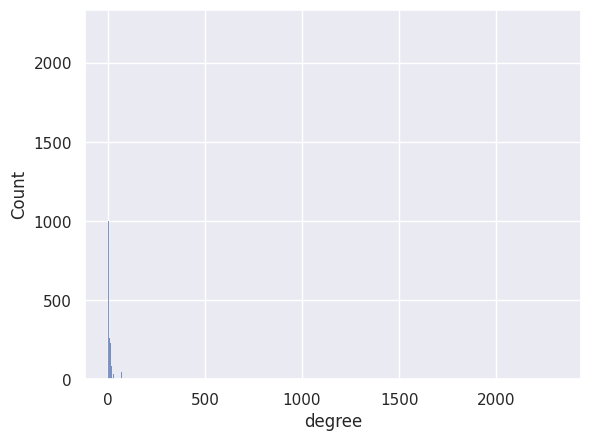

In [24]:
sns.histplot(cord19['degree'])
cord19['degree'].describe()

In [17]:
gt_save(g, './cord19_graph.net.gz')
g = gt_load('./cord19_graph.net.gz')
m = gt_draw.sfdp_layout(g)
gt_move(g, m)
r=netpixi.render('./cord19_graph.net.gz')

In [18]:
g = gt_clean(g)
m = gt_draw.sfdp_layout(g)
gt_move(g, m)
gt_save(g, './cord19_graph.net.gz')
r = netpixi.render('./cord19_graph.net.gz', infinite=True)